# Transducers in PhotoAcoustic.jl

One of the main compoenent of real world photoacoustic imaging and inversion, and more generally medical wave-equation based inversion (ultrasound, ...) is the necessity to model transducers properly.

Therefore, in Photoacoustic, we offer a simpler but effective implementation of a transducer as a plane (line in 2D) dipole. In the following we illustrate the usage of transducer and highligh the impace on the wavefield

In [1]:
using PhotoAcoustic, SlimPlotting, PyPlot, JUDI

# Model

For illustration purpose, we consider a simpel constant velocity model

In [2]:
n, d, o = (201, 201), (0.08, 0.08), (0., 0.)
model = Model(n, d, o, 1.5f0 * ones(Float32, 201, 201))

Model (n=(201, 201), d=(0.08f0, 0.08f0), o=(0.0f0, 0.0f0)) with parameters [:m]

# Geometry

Let's now define our acquisition geometry as a circle and visualize it on top of the model.

In [3]:
# Set up receiver geometry
ntransducers = 64
domain_x = (n[1] - 1)*d[1]
domain_z = (n[2] - 1)*d[2]
rad = .95*domain_x / 2
xrec, zrec, theta = circle_geom(domain_x / 2, domain_z / 2, rad, ntransducers)
yrec = 0f0 # 2d so always 0
xsrc, ysrc, zsrc = [Float32(domain_x * .5f0)], [0f0], [Float32(domain_z * .5f0)]

(Float32[8.0], Float32[0.0], Float32[8.0])

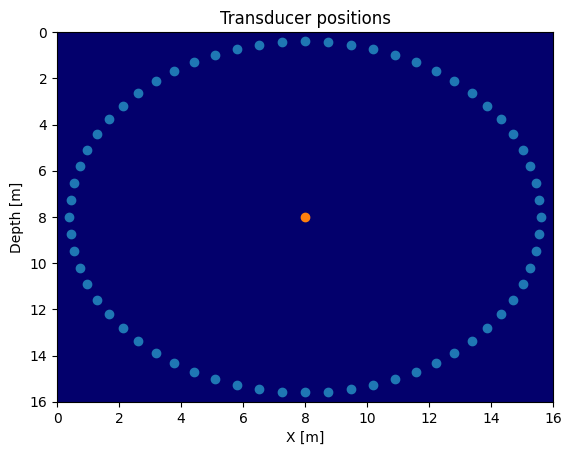

In [4]:
scatter(xrec, zrec)
scatter(xsrc, zsrc)
plot_velocity(model.m; new_fig=false, name="Transducer positions")

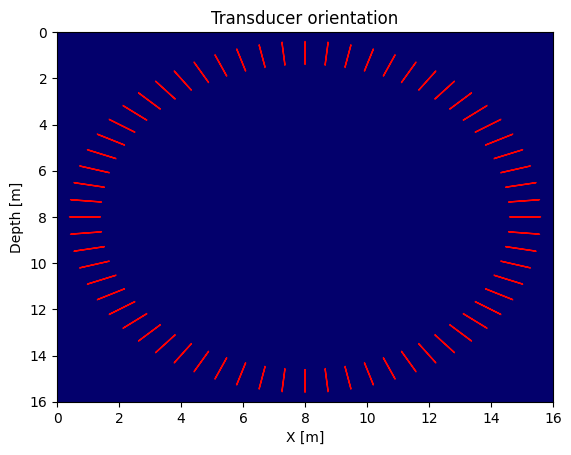

In [5]:
plot_velocity(model.m; new_fig=false, name="Transducer orientation")
for t=1:ntransducers
    # y pointing down convention so need the minus sign
    dx, dy = -1 .* sincos(theta[t] - pi/2)
    arrow(x=xrec[t], y=zrec[t], dx=dx, dy=dy, color="r")
end

# Propagators

With our geometry define, we can create our propagators and comapre the data with what a point receiver would record. Because we. designed PhotoAcoustic to be an extension of JUDI, we can for this tutorial ignore the initial state propagation and focus on point source propagation for illustration purposes.

In [6]:
dt = 0.01f0 # microseconds
time_rec = 15f0 # microseconds
f0 = .01f0/dt # 100 MHz
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time_rec, nsrc=1)

GeometryIC{Float32} wiht 1 sources


In [7]:
Ainv = judiModeling(model; options=Options(space_order=16))

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

In [8]:
Pr = judiProjection(recGeometry)
Prtrans = judiTransducerProjection(recGeometry, d[1], .25f0, [theta])

┌ Warning: Only one angle provided, assuming 2D model
└ @ PhotoAcoustic /Users/mathiaslouboutin/.julia/dev/PhotoAcoustic/src/transducer.jl:71


judiProjection{Float32}(AbstractSize(Dict{Symbol, Any}(:src => 1, :rec => [64], :time => Integer[1501])), AbstractSize(Dict{Symbol, Any}(:x => 0, :src => 1, :y => 0, :z => 0, :time => Integer[1501])), PhotoAcoustic.TransducerGeometry{Float32, 0.08f0} wiht 1 sources)

In [9]:
function sinfun(f0, dt, time_rec)
    time = Float32.(0f0:dt:time_rec)
    return reshape(Float32.(sin.(2 * time .* pi * f0)), : ,1)
end

sinfun (generic function with 1 method)

In [10]:
# Simple point source
srcGeom = Geometry(xsrc, ysrc, zsrc; dt=dt, t=time_rec)
Ps = judiProjection(srcGeom)
Pstrans = judiTransducerProjection(srcGeom, d[1], [[.25f0]], [[0f0]]) # Transducer as source
q = judiVector(srcGeom, sinfun(f0, dt, time_rec))

┌ Warning: Only one angle provided, assuming 2D model
└ @ PhotoAcoustic /Users/mathiaslouboutin/.julia/dev/PhotoAcoustic/src/transducer.jl:71


judiVector{Float32, Matrix{Float32}} with 1 sources


# Propagation

We can now propagate and look at our difference fields. We can clearly see differences in directivity.

In [11]:
d_pp = Pr * Ainv * Ps' *q

Building forward operator
Operator `forward` ran in 0.04 s


judiVector{Float32, Matrix{Float32}} with 1 sources


In [12]:
d_pt = Pr * Ainv * Pstrans' *q

Operator `forward` ran in 0.04 s


judiVector{Float32, Matrix{Float32}} with 1 sources


In [13]:
d_tp = Prtrans * Ainv * Ps' *q

Operator `forward` ran in 0.05 s


judiVector{Float32, Matrix{Float32}} with 1 sources


In [14]:
d_tt = Prtrans * Ainv * Pstrans' *q

Operator `forward` ran in 0.05 s


judiVector{Float32, Matrix{Float32}} with 1 sources


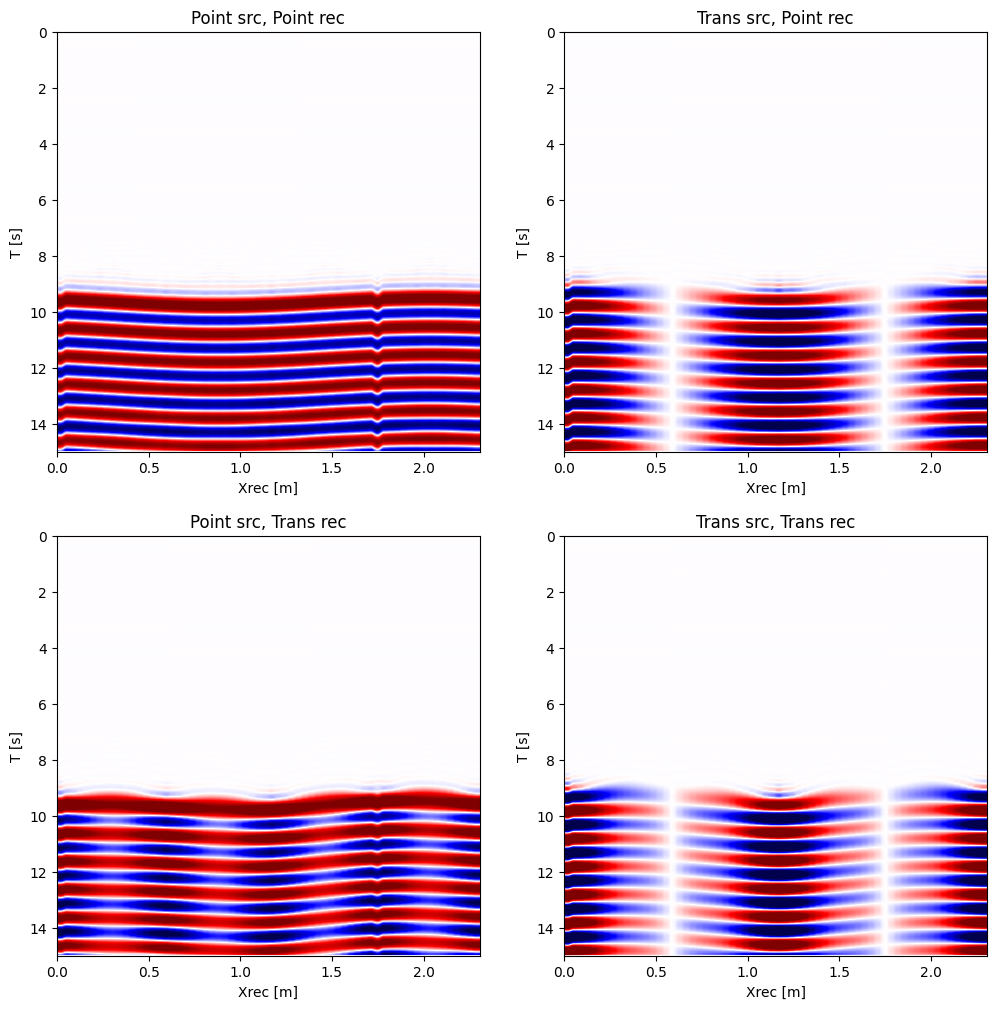

In [15]:
figure(figsize=(12, 12))
subplot(221)
plot_sdata(d_pp; cmap="seismic", name="Point src, Point rec", new_fig=false)
subplot(222)
plot_sdata(d_pt; cmap="seismic", name="Trans src, Point rec", new_fig=false)
subplot(223)
plot_sdata(d_tp; cmap="seismic", name="Point src, Trans rec", new_fig=false)
subplot(224)
plot_sdata(d_tt; cmap="seismic", name="Trans src, Trans rec", new_fig=false)

Since we are fully comaptible with standard JUDI propagation, we can also directly look at the wavefield for a better understanding

In [16]:
u_p = Ainv * Ps' * q

Building forward operator
Operator `forward` ran in 0.04 s


judiWavefield{Float32} with 1 sources


In [17]:
u_t = Ainv * Pstrans' *q

Operator `forward` ran in 0.04 s


judiWavefield{Float32} with 1 sources


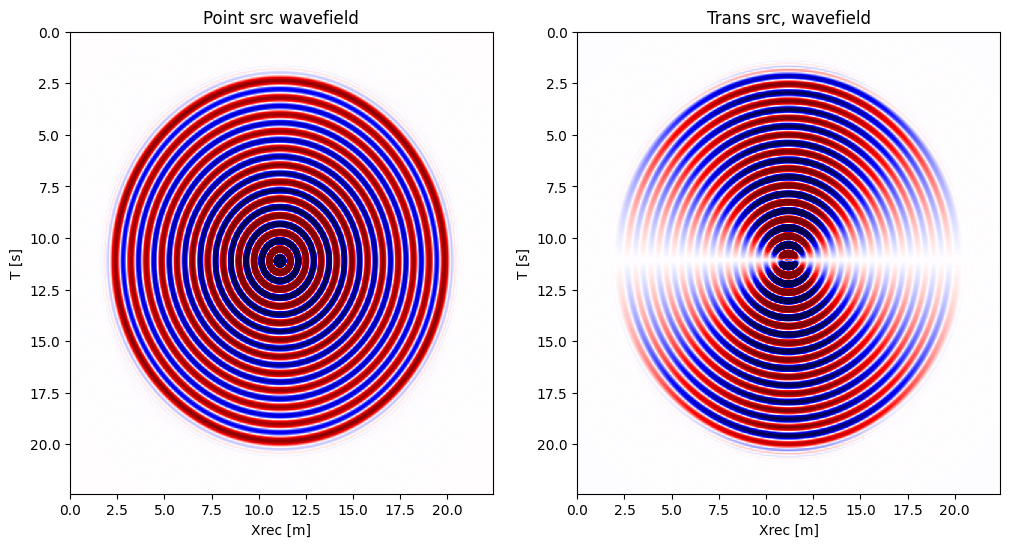

In [18]:
figure(figsize=(12, 6))
subplot(121)
plot_sdata(u_p.data[1][300, :, :], d; cmap="seismic", name="Point src wavefield", new_fig=false)
subplot(122)
plot_sdata(u_t.data[1][300, :, :], d; cmap="seismic", name="Trans src, wavefield", new_fig=false)

Let's change the orientation of the source and see the difference

In [19]:
Pstrans.geometry.θ[1][1] = Float32(pi/4)

0.7853982f0

In [20]:
u_t = Ainv * Pstrans' *q

Operator `forward` ran in 0.04 s


judiWavefield{Float32} with 1 sources


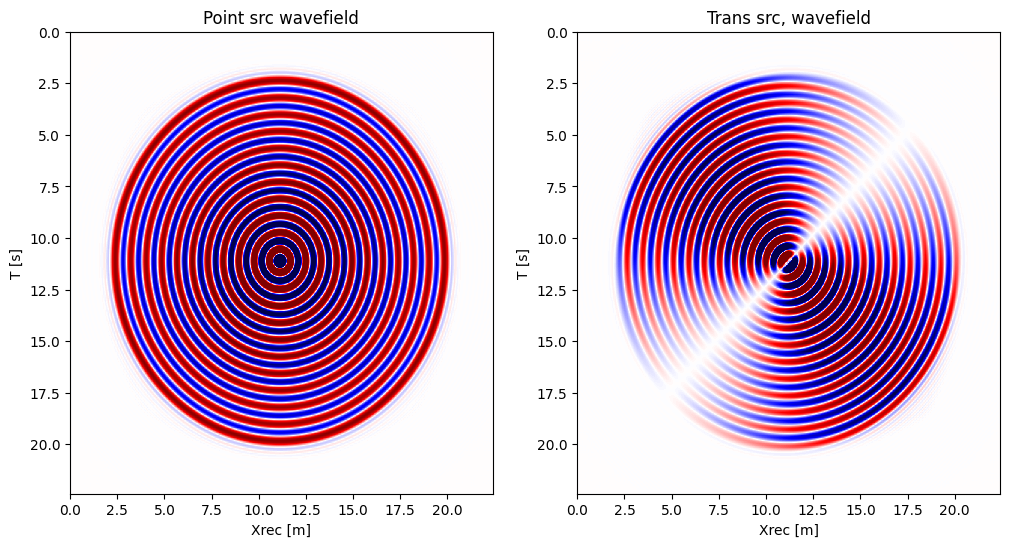

In [21]:
figure(figsize=(12, 6))
subplot(121)
plot_sdata(u_p.data[1][300, :, :], d; cmap="seismic", name="Point src wavefield", new_fig=false)
subplot(122)
plot_sdata(u_t.data[1][300, :, :], d; cmap="seismic", name="Trans src, wavefield", new_fig=false)

Now let's change the radius and the frequency of the transducer to highligh the directionality

In [22]:
Pstrans.geometry.θ[1][1] = 0f0
Pstrans.geometry.r[1][1] = Float32(5 * d[1])

0.4f0

In [23]:
time = reshape(0f0:dt:time_rec, 1501 ,1)
f0 = 2.5f0
q2 = judiVector(deepcopy(srcGeom), sinfun(f0, dt, time_rec))

judiVector{Float32, Matrix{Float32}} with 1 sources


In [24]:
u_t = Ainv * Pstrans' * q2

Operator `forward` ran in 0.04 s


judiWavefield{Float32} with 1 sources


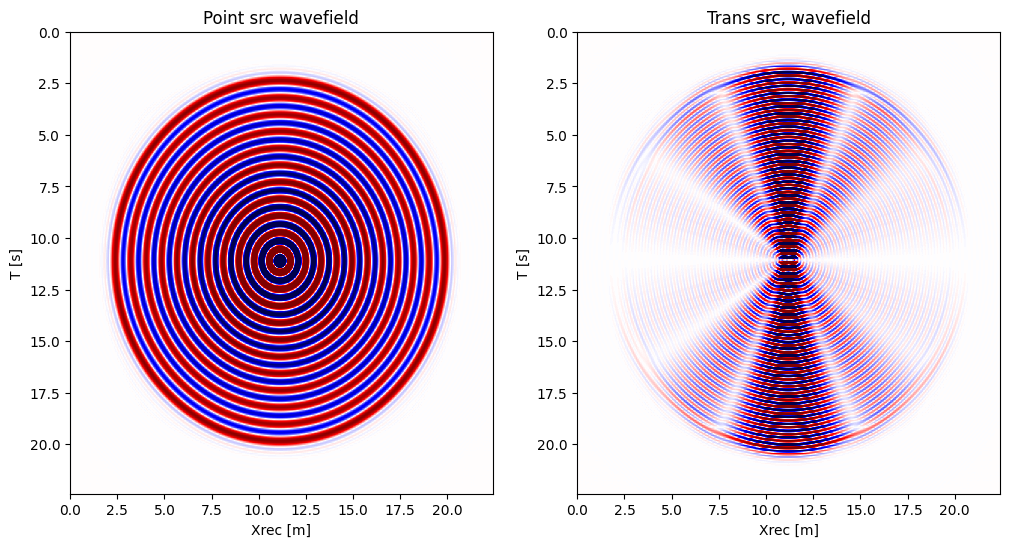

In [25]:
figure(figsize=(12, 6))
subplot(121)
plot_sdata(u_p.data[1][300, :, :], d; cmap="seismic", name="Point src wavefield", new_fig=false)
subplot(122)
plot_sdata(u_t.data[1][300, :, :], d; cmap="seismic", name="Trans src, wavefield", new_fig=false)